In [281]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import torch
from d2l import torch as d2l
from torch.utils import data
from IPython import display
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# Specify the path to your text file
file_path = 'csie.ntu.edu.tw_~cjlin_libsvmtools_datasets_binary_diabetes_scale.txt'

# Initialize empty lists to store data
labels = []
data = []

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Split each line into label and features
        parts = line.strip().split()
        label = int(parts[0])  # Extract the label (+1 or -1)
        features = {}
        for part in parts[1:]:
            idx, value = part.split(':')
            features[int(idx)] = float(value)
        
        # Append the label and features to the respective lists
        labels.append(label)
        data.append(features)

# Create a DataFrame from the lists
df = pd.DataFrame(data)
df['label'] = labels  # Add a 'label' column to the DataFrame
df['label'] = df['label'].replace(-1, 0)
# If you want to specify column names for the features (1, 2, 3, ...), you can do so like this:
# df.columns = [str(i) for i in range(1, len(df.columns))]

# Now you have a DataFrame with the content of your text file
df.head()

df.shape



(768, 9)

# Data Pre-processing

## Delete Nan Values

In [282]:
print(df.isna().sum().sum())
df = df.dropna()

9


## Data Split

In [283]:
train_df, remaining_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=0)
valid_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['label'], random_state=0)

train_df["label"].value_counts(),test_df["label"].value_counts(), valid_df["label"].value_counts()



(label
 1    347
 0    184
 Name: count, dtype: int64,
 label
 1    74
 0    40
 Name: count, dtype: int64,
 label
 1    75
 0    39
 Name: count, dtype: int64)

## Processing Imbalance

In [284]:
from imblearn.over_sampling import SMOTE

train_arry = train_df.to_numpy()
test_arry = test_df.to_numpy()
valid_arry = valid_df.to_numpy()
print(train_arry.shape,test_arry.shape)

train_features = train_arry[:,0:-1]
train_labels = train_arry[:,-1]
test_features = test_arry[:,0:-1]
test_labels = test_arry[:,-1]
valid_features = valid_arry[:,0:-1]
valid_labels = valid_arry[:,-1]

# oversample = SMOTE()
# train_features_new, train_labels_new = oversample.fit_resample(train_features, train_labels)
# pd.Series(train_labels_new).value_counts(),pd.DataFrame(train_features_new).shape

(531, 9) (114, 9)


In [285]:

train_features_tensor = torch.Tensor(train_features)
train_labels_tensor = torch.Tensor(train_labels).to(torch.float32).reshape(-1, 1) 

test_features_tensor = torch.Tensor(test_features)
test_labels_tensor = torch.Tensor(test_labels).to(torch.float32).reshape(-1, 1)

valid_features_tensor = torch.Tensor(valid_features)
valid_labels_tensor = torch.Tensor(valid_labels).to(torch.float32).reshape(-1, 1)  

# trainset = TensorDataset(train_features_tensor, train_labels_tensor)
# testset = TensorDataset(test_features_tensor, test_labels_tensor)

print(test_features_tensor)

tensor([[ 0.0588,  0.3467,  0.2131, -0.3333, -0.8582, -0.2280, -0.6738,  1.0000],
        [-0.8824,  0.5779,  0.1803, -0.5758, -0.6028, -0.2370, -0.9616, -0.9000],
        [-0.6471,  0.1156, -0.0492, -0.3737, -0.8960, -0.1207, -0.6994, -0.9667],
        [ 0.1765,  0.7990,  0.1475, -1.0000, -1.0000,  0.0462, -0.8958, -0.4667],
        [-1.0000, -0.2563, -0.1475, -0.7980, -0.9149, -0.1714, -0.8369, -0.9667],
        [-0.1765, -0.3769,  0.2787, -1.0000, -1.0000, -0.0283, -0.7327, -0.3333],
        [-0.2941,  0.3467,  0.1475, -0.5354, -0.6927,  0.0551, -0.6038, -0.7333],
        [-0.8824, -0.0452,  0.0820, -0.7374, -0.9102, -0.4158, -0.7814, -0.8667],
        [-0.7647, -0.4372, -0.0820, -0.4343, -0.8936, -0.2787, -0.7831, -0.9667],
        [-0.8824, -0.2864, -0.2131, -0.6364, -0.8203, -0.3920, -0.7908, -0.9667],
        [-0.7647,  0.2261,  0.1475, -0.4545, -1.0000,  0.0969, -0.7763, -0.8000],
        [-0.1765,  0.5075,  0.0820, -0.1515, -0.1915,  0.0343, -0.4535, -0.3000],
        [-0.2941

In [286]:

# X = train_features_tensor.to_numpy(dtype=np.float32)
# y = train_labels_tensor.to_numpy(dtype=np.float32).reshape(-1, 1) 
# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
X = train_features_tensor
y = train_labels_tensor

import torch.nn as nn

seed = 0 # seed
torch.manual_seed(seed)  # set PyTorch global seed
random.seed(seed)        
np.random.seed(seed)

model = nn.Sequential(
  nn.Linear(8, 1),
  nn.Sigmoid() 
)
print(model)

# def init_weights(m):
#     if type(m) == nn.Linear:
#         nn.init.normal_(m.weight, std=0.01)

# model.apply(init_weights);

def mlp(n_epochs,batch_size,model,Xtrain,Ytrain,Xtest,Ytest,lr=0.1):
    loss_fn = nn.BCELoss() # binary cross-entropy
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    n_epochs = n_epochs
    batch_size = batch_size
    accuracy_lst = []
    accuracy_test_lst = []
    loss_lst = []
    for epoch in range(n_epochs):
        for i in range(0, len(Xtrain), batch_size):
            Xbatch = Xtrain[i:i+batch_size]
            y_pred = model(Xbatch)
            ybatch = Ytrain[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad() # clear the last gradient
            loss.backward() # nn.BCELoss() return a scale value for loss
                            # other loss function like mse may use loss.mean().backward() to caculate the mena of loss and then caculate gradient 
            optimizer.step()# update the W and b
        
        loss_lst.append(loss)
        y_pred = model(Xtrain)
        
        accuracy = (y_pred.round() == Ytrain).float().mean()
        accuracy_lst.append(accuracy)
    
        ytest_pred = model(Xtest)
        
        accuracy_test = (ytest_pred.round() == Ytest).float().mean()
        accuracy_test_lst.append(accuracy_test)
        
        param_lst = [batch_size, model, lr]
    
        print(f'Finished epoch {epoch}, latest loss {loss},accuracy {accuracy},accuracy_valid {accuracy_test}')
    return loss_lst, accuracy_lst, accuracy_test_lst, param_lst

n_epochs =500
batch_size = 20
loss_lst, accuracy_lst, accuracy_test_lst, param_lst= mlp(n_epochs
                                                ,batch_size
                                                ,model 
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,valid_features_tensor
                                                ,valid_labels_tensor)


Sequential(
  (0): Linear(in_features=8, out_features=1, bias=True)
  (1): Sigmoid()
)
Finished epoch 0, latest loss 0.5831069350242615,accuracy 0.6553672552108765,accuracy_valid 0.6491228342056274
Finished epoch 1, latest loss 0.5691214799880981,accuracy 0.6591337323188782,accuracy_valid 0.6491228342056274
Finished epoch 2, latest loss 0.5628350377082825,accuracy 0.6704331636428833,accuracy_valid 0.6578947305679321
Finished epoch 3, latest loss 0.5580042600631714,accuracy 0.6892655491828918,accuracy_valid 0.6842105388641357
Finished epoch 4, latest loss 0.5538750290870667,accuracy 0.7043314576148987,accuracy_valid 0.6929824352264404
Finished epoch 5, latest loss 0.5502614378929138,accuracy 0.7118644118309021,accuracy_valid 0.6929824352264404
Finished epoch 6, latest loss 0.5470616817474365,accuracy 0.7250470519065857,accuracy_valid 0.6929824352264404


Finished epoch 7, latest loss 0.5442007780075073,accuracy 0.7401130199432373,accuracy_valid 0.7017543911933899
Finished epoch 8, latest loss 0.5416201949119568,accuracy 0.7476459741592407,accuracy_valid 0.7017543911933899
Finished epoch 9, latest loss 0.5392745137214661,accuracy 0.7476459741592407,accuracy_valid 0.7105262875556946
Finished epoch 10, latest loss 0.537128210067749,accuracy 0.7570621371269226,accuracy_valid 0.7105262875556946
Finished epoch 11, latest loss 0.5351538062095642,accuracy 0.7476459741592407,accuracy_valid 0.7105262875556946
Finished epoch 12, latest loss 0.533329427242279,accuracy 0.7551789283752441,accuracy_valid 0.719298243522644
Finished epoch 13, latest loss 0.5316376090049744,accuracy 0.7589454054832458,accuracy_valid 0.7368420958518982
Finished epoch 14, latest loss 0.5300642848014832,accuracy 0.7608286142349243,accuracy_valid 0.7368420958518982
Finished epoch 15, latest loss 0.5285978317260742,accuracy 0.7589454054832458,accuracy_valid 0.754385948181152

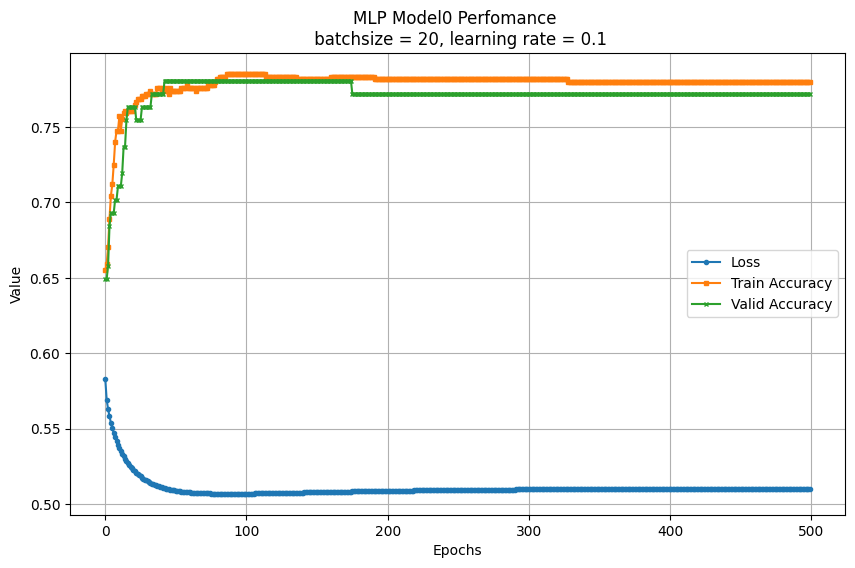

In [287]:

def learn_curve(n_epochs,loss_lst,accuracy_lst,accuracy_test_lst,param_lst, model_number = 0,title = f'MLP'):
    epochs = range(n_epochs)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [loss.detach().numpy() for loss in loss_lst], label='Loss', marker='o', markersize=3)
    plt.plot(epochs, [accuracy.detach().numpy() for accuracy in accuracy_lst], label='Train Accuracy', marker='s', markersize=3)
    plt.plot(epochs, [accuracy_test.detach().numpy() for accuracy_test in accuracy_test_lst], label='Valid Accuracy', marker='x', markersize=3)

    plt.title(f"{title} Model{model_number} Perfomance \n batchsize = {param_lst[0]}, learning rate = {param_lst[2]}")
    plt.xlabel('Epochs')
    plt.ylabel('Value')

    plt.legend()
    plt.grid(True)
    plt.show()

learn_curve(n_epochs,loss_lst,accuracy_lst,accuracy_test_lst,param_lst)
# model.eval()
# with torch.no_grad():
#     y_pred = model(test_features_tensor)
# accuracy = (y_pred.round() == test_labels_tensor).float().mean()
# print(f"Accuracy {accuracy}")

In [288]:
model = nn.Sequential(
  nn.Linear(8, 1),
  nn.Sigmoid()
)

model_state_dict = model.state_dict()
# check the value of W and b
for param_name, param_value in model_state_dict.items():
    print(f'Parameter name: {param_name}')
    print(f'Parameter value: {param_value}')

Parameter name: 0.weight
Parameter value: tensor([[ 0.0936, -0.1068, -0.0695, -0.3378, -0.2342, -0.1457,  0.0131,  0.1398]])
Parameter name: 0.bias
Parameter value: tensor([0.2121])


# Hyperparameter Adjustment
## Different Layers

In [289]:
model3 = nn.Sequential(
  nn.Linear(8, 6),
  nn.ReLU(),
  nn.Linear(6, 4),
  nn.ReLU(),
  nn.Linear(4, 2),
  nn.ReLU(),
  nn.Linear(2, 1),
  nn.Sigmoid()    
)

model2 = nn.Sequential(
  nn.Linear(8, 4),
  nn.ReLU(),
  nn.Linear(4, 2),
  nn.ReLU(),
  nn.Linear(2, 1),
  nn.Sigmoid()    
)

model1 = nn.Sequential(
  nn.Linear(8, 4),
  nn.ReLU(),
  nn.Linear(4, 1),
  nn.Sigmoid()    
)
torch.save(model1.state_dict(), 'original_model1.pth')
torch.save(model2.state_dict(), 'original_model2.pth')
torch.save(model3.state_dict(), 'original_model3.pth')
torch.save(model.state_dict(), 'original_model.pth')
print(model)
print("****************************************************************")
print(model1)
print("****************************************************************")
print(model2)
print("****************************************************************")
print(model3)

Sequential(
  (0): Linear(in_features=8, out_features=1, bias=True)
  (1): Sigmoid()
)
****************************************************************
Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)
****************************************************************
Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=1, bias=True)
  (5): Sigmoid()
)
****************************************************************
Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=1, bias=True)
  (7): Sigmoid()
)


Finished epoch 0, latest loss 0.6392530202865601,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 1, latest loss 0.5914888381958008,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 2, latest loss 0.5797209143638611,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 3, latest loss 0.574092447757721,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 4, latest loss 0.568724513053894,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 5, latest loss 0.563807487487793,accuracy 0.6553672552108765,accuracy_valid 0.6666666865348816
Finished epoch 6, latest loss 0.5586681962013245,accuracy 0.7080979347229004,accuracy_valid 0.6842105388641357
Finished epoch 7, latest loss 0.5529453754425049,accuracy 0.7250470519065857,accuracy_valid 0.7017543911933899
Finished epoch 8, latest loss 0.5468486547470093,accuracy 0.7382297515869141,accuracy_valid 0.6929824352264404
Fini

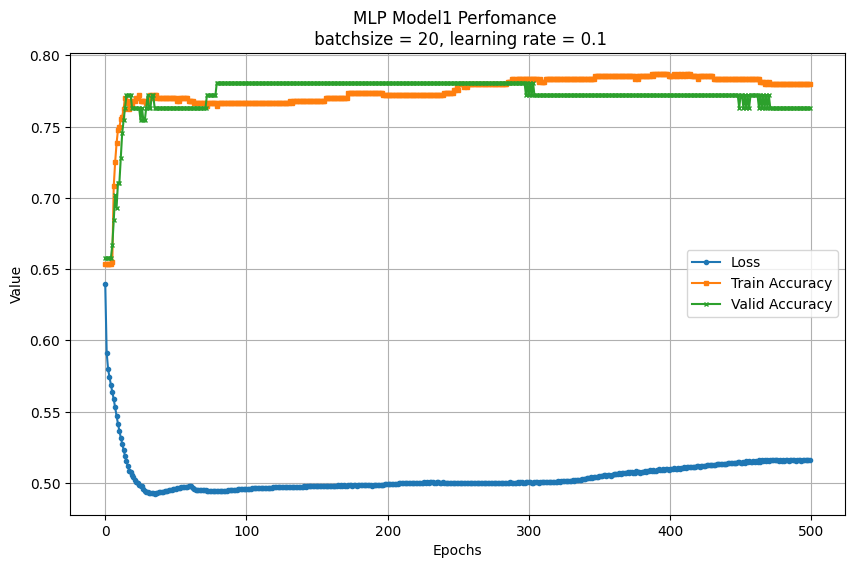

Finished epoch 0, latest loss 0.6487470865249634,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 1, latest loss 0.6195616722106934,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 2, latest loss 0.6081183552742004,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 3, latest loss 0.60312420129776,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 4, latest loss 0.6007168889045715,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 5, latest loss 0.5995351672172546,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 6, latest loss 0.5989280939102173,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 7, latest loss 0.5985841155052185,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 8, latest loss 0.5984048843383789,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Fin

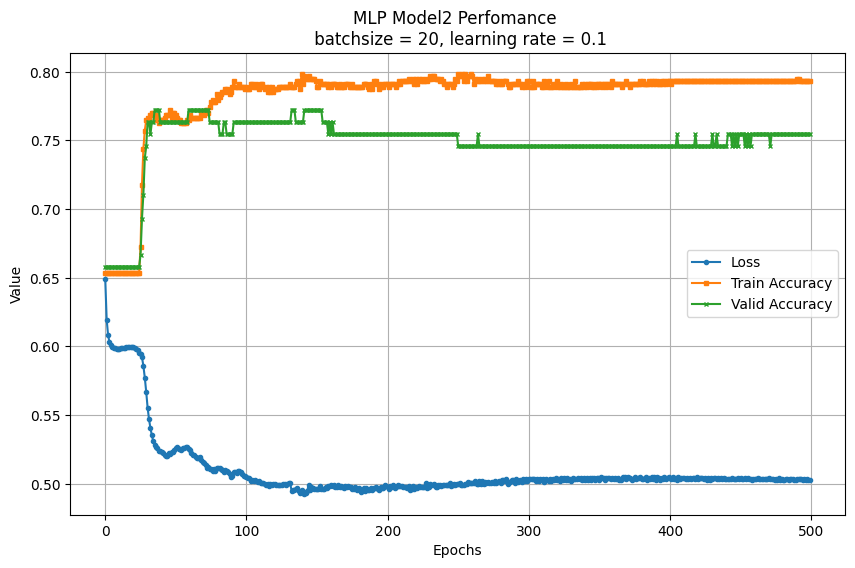

Finished epoch 0, latest loss 0.676936149597168,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 1, latest loss 0.6294302344322205,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 2, latest loss 0.6121951341629028,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 3, latest loss 0.6049481630325317,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 4, latest loss 0.6015921831130981,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 5, latest loss 0.5999340415000916,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 6, latest loss 0.599082350730896,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 7, latest loss 0.5986364483833313,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 8, latest loss 0.5983968377113342,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Fin

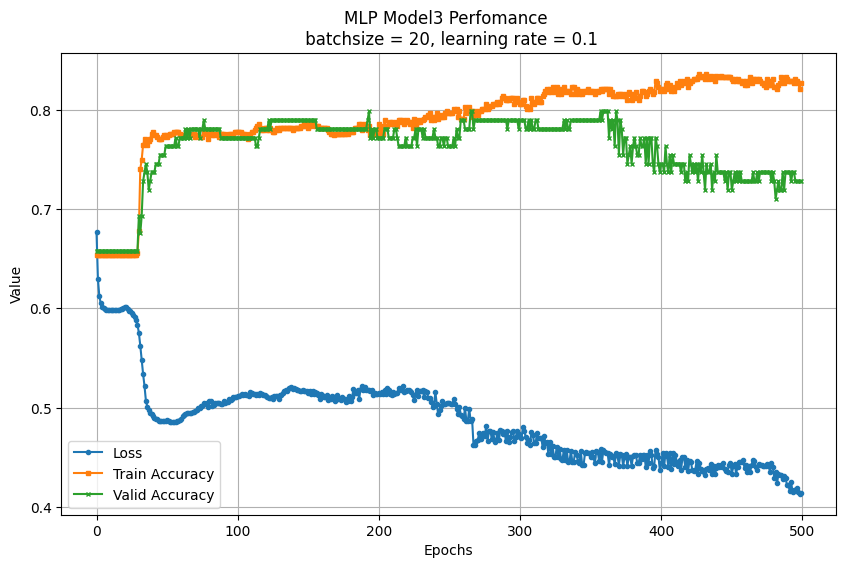

In [290]:

n_epochs = 500
batch_size = 20

# loss_lst_dict = {}
# for i in [1, 2, 3]:
#     loss_lst, accuracy_lst, accuracy_test_lst, param_lst = mlp(n_epochs, batch_size, model1,
#                                                     train_features_tensor, train_labels_tensor,
#                                                     test_features_tensor, test_labels_tensor,lr = 0.05)
    
#     loss_lst_dict[f'loss_lst{i}'] = loss_lst
#     loss_lst_dict[f'loss_lst{i}'] = loss_lst
#     # 调用 learn_curve 函数
#     learn_curve(n_epochs, loss_lst, accuracy_lst, accuracy_test_lst, param_lst, model_number = 0,title = f'MLP')

loss_lst1, accuracy_lst1, accuracy_test_lst1,param_lst1 = mlp(n_epochs
                                                ,batch_size
                                                ,model1 
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,valid_features_tensor
                                                ,valid_labels_tensor)
learn_curve(n_epochs,loss_lst1,accuracy_lst1,accuracy_test_lst1,param_lst1, model_number = 1,title = f'MLP')

loss_lst2, accuracy_lst2, accuracy_test_lst2,param_lst2 = mlp(n_epochs
                                                ,batch_size
                                                ,model2
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,valid_features_tensor
                                                ,valid_labels_tensor)
learn_curve(n_epochs,loss_lst2,accuracy_lst2,accuracy_test_lst2,param_lst2,model_number = 2,title = f'MLP')

loss_lst3, accuracy_lst3, accuracy_test_lst3,param_lst3 = mlp(n_epochs
                                                ,batch_size
                                                ,model3
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,valid_features_tensor
                                                ,valid_labels_tensor)
learn_curve(n_epochs,loss_lst3,accuracy_lst3,accuracy_test_lst3,param_lst3,model_number = 3,title = f'MLP')

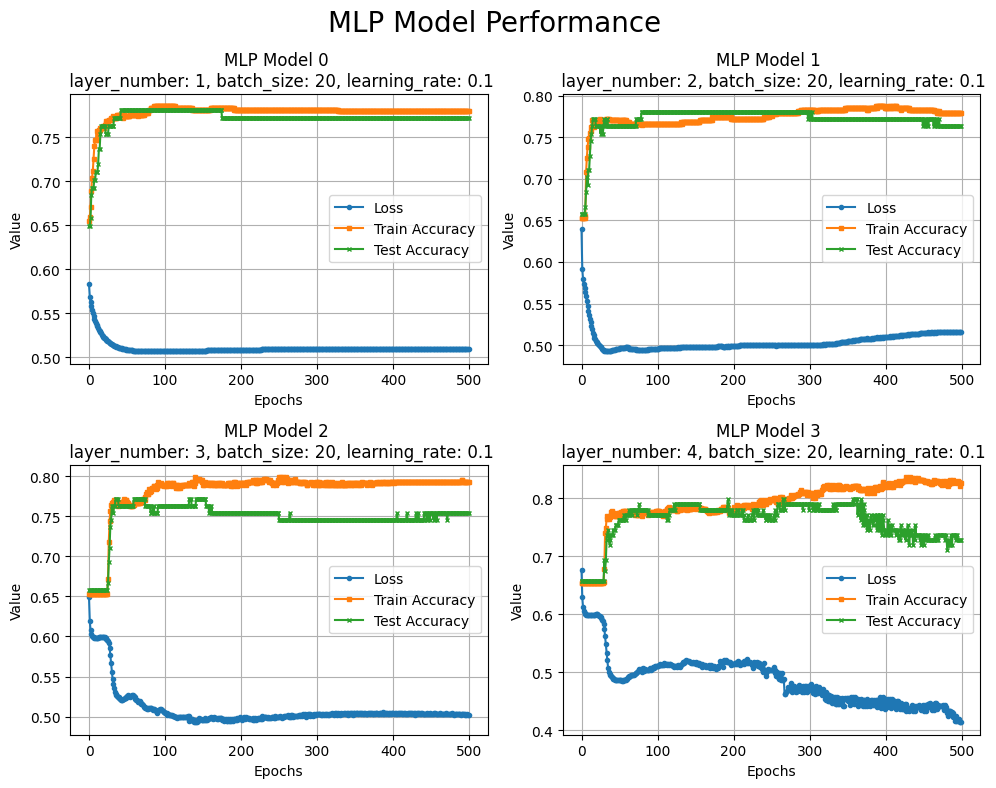

In [297]:
epochs = range(n_epochs)
# Create a figure with 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("MLP Model Performance", fontsize=20)

# Plot the first learning curve
axes[0, 0].plot(epochs, [loss.detach().numpy() for loss in loss_lst], label='Loss', marker='o', markersize=3)
axes[0, 0].plot(epochs, [accuracy.detach().numpy() for accuracy in accuracy_lst], label='Train Accuracy', marker='s', markersize=3)
axes[0, 0].plot(epochs, [accuracy_test.detach().numpy() for accuracy_test in accuracy_test_lst], label='Test Accuracy', marker='x', markersize=3)
axes[0, 0].set_title("MLP Model 0 \n layer_number: 1, batch_size: 20, learning_rate: 0.1")
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot the second learning curve
axes[0, 1].plot(epochs, [loss.detach().numpy() for loss in loss_lst1], label='Loss', marker='o', markersize=3)
axes[0, 1].plot(epochs, [accuracy.detach().numpy() for accuracy in accuracy_lst1], label='Train Accuracy', marker='s', markersize=3)
axes[0, 1].plot(epochs, [accuracy_test.detach().numpy() for accuracy_test in accuracy_test_lst1], label='Test Accuracy', marker='x', markersize=3)
axes[0, 1].set_title("MLP Model 1 \n layer_number: 2, batch_size: 20, learning_rate: 0.1")
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot the third learning curve
axes[1, 0].plot(epochs, [loss.detach().numpy() for loss in loss_lst2], label='Loss', marker='o', markersize=3)
axes[1, 0].plot(epochs, [accuracy.detach().numpy() for accuracy in accuracy_lst2], label='Train Accuracy', marker='s', markersize=3)
axes[1, 0].plot(epochs, [accuracy_test.detach().numpy() for accuracy_test in accuracy_test_lst2], label='Test Accuracy', marker='x', markersize=3)
axes[1, 0].set_title("MLP Model 2 \n layer_number: 3, batch_size: 20, learning_rate: 0.1")
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot the fourth learning curve
axes[1, 1].plot(epochs, [loss.detach().numpy() for loss in loss_lst3], label='Loss', marker='o', markersize=3)
axes[1, 1].plot(epochs, [accuracy.detach().numpy() for accuracy in accuracy_lst3], label='Train Accuracy', marker='s', markersize=3)
axes[1, 1].plot(epochs, [accuracy_test.detach().numpy() for accuracy_test in accuracy_test_lst3], label='Test Accuracy', marker='x', markersize=3)
axes[1, 1].set_title("MLP Model 3 \n layer_number: 4, batch_size: 20, learning_rate: 0.1")
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()







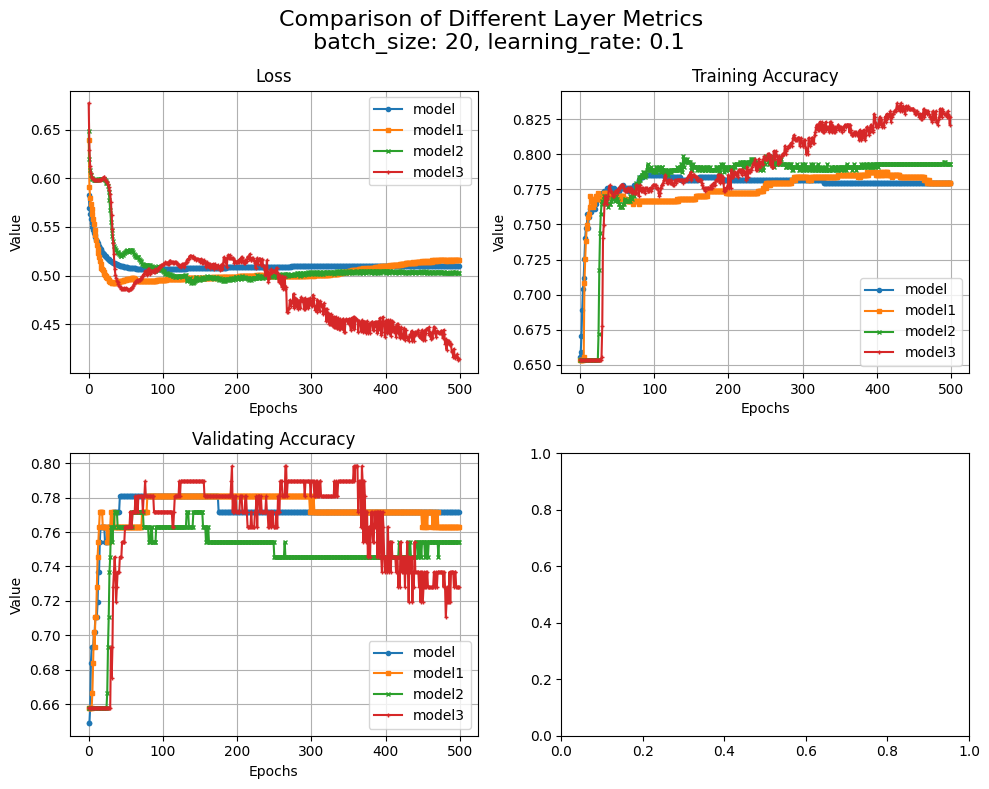

In [298]:
epochs = range(n_epochs)
# Create a figure with 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Comparison of Different Layer Metrics \n batch_size: 20, learning_rate: 0.1", fontsize=16)

# Plot the first learning curve

axes[0, 0].plot(epochs, [loss.detach().numpy() for loss in loss_lst], label="model", marker='o', markersize=3)
axes[0, 0].plot(epochs, [loss1.detach().numpy() for loss1 in loss_lst1], label="model1", marker='s', markersize=3)
axes[0, 0].plot(epochs, [loss2.detach().numpy() for loss2 in loss_lst2], label="model2", marker='x', markersize=3)
axes[0, 0].plot(epochs, [loss3.detach().numpy() for loss3 in loss_lst3], label="model3", marker='+', markersize=3)
axes[0, 0].set_title("Loss")
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot the second learning curve
axes[0, 1].plot(epochs, [loss.detach().numpy() for loss in accuracy_lst], label="model", marker='o', markersize=3)
axes[0, 1].plot(epochs, [loss1.detach().numpy() for loss1 in accuracy_lst1], label="model1", marker='s', markersize=3)
axes[0, 1].plot(epochs, [loss2.detach().numpy() for loss2 in accuracy_lst2], label="model2", marker='x', markersize=3)
axes[0, 1].plot(epochs, [loss3.detach().numpy() for loss3 in accuracy_lst3], label="model3", marker='+', markersize=3)
axes[0, 1].set_title("Training Accuracy")
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot the third learning curve
axes[1, 0].plot(epochs, [loss.detach().numpy() for loss in accuracy_test_lst], label="model", marker='o', markersize=3)
axes[1, 0].plot(epochs, [loss1.detach().numpy() for loss1 in accuracy_test_lst1], label="model1", marker='s', markersize=3)
axes[1, 0].plot(epochs, [loss2.detach().numpy() for loss2 in accuracy_test_lst2], label="model2", marker='x', markersize=3)
axes[1, 0].plot(epochs, [loss3.detach().numpy() for loss3 in accuracy_test_lst3], label="model3", marker='+', markersize=3)
axes[1, 0].set_title("Validating Accuracy")
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

## Learning Rate

In [300]:
lr_lst = [0.005,0.05,0.1,2.5]
loss_array = []
accuracy_array=[]
accuracy_test_array=[]
n_epochs = 400
batch_size = 20

epochs = range(n_epochs)

for i,value in enumerate(lr_lst):
    model1.load_state_dict(torch.load('original_model1.pth'))
    model1.zero_grad()
    loss_lst, accuracy_lst, accuracy_test_lst,_ = mlp(n_epochs
                                                ,batch_size
                                                ,model1 
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,valid_features_tensor
                                                ,valid_labels_tensor
                                                ,lr = value)
    loss_array.append([loss.detach().numpy() for loss in loss_lst])
    accuracy_array.append([loss.detach().numpy() for loss in accuracy_lst])
    accuracy_test_array.append([loss.detach().numpy() for loss in accuracy_test_lst])
    


Finished epoch 0, latest loss 0.8108459115028381,accuracy 0.3465160131454468,accuracy_valid 0.34210526943206787
Finished epoch 1, latest loss 0.7947792410850525,accuracy 0.3465160131454468,accuracy_valid 0.34210526943206787
Finished epoch 2, latest loss 0.7799314856529236,accuracy 0.3465160131454468,accuracy_valid 0.34210526943206787
Finished epoch 3, latest loss 0.7662830352783203,accuracy 0.3465160131454468,accuracy_valid 0.34210526943206787
Finished epoch 4, latest loss 0.7536616921424866,accuracy 0.3465160131454468,accuracy_valid 0.34210526943206787
Finished epoch 5, latest loss 0.7423238754272461,accuracy 0.3465160131454468,accuracy_valid 0.34210526943206787
Finished epoch 6, latest loss 0.7318724989891052,accuracy 0.3446327745914459,accuracy_valid 0.34210526943206787
Finished epoch 7, latest loss 0.7224125862121582,accuracy 0.3408662974834442,accuracy_valid 0.35087719559669495
Finished epoch 8, latest loss 0.7128843665122986,accuracy 0.33521658182144165,accuracy_valid 0.342105269

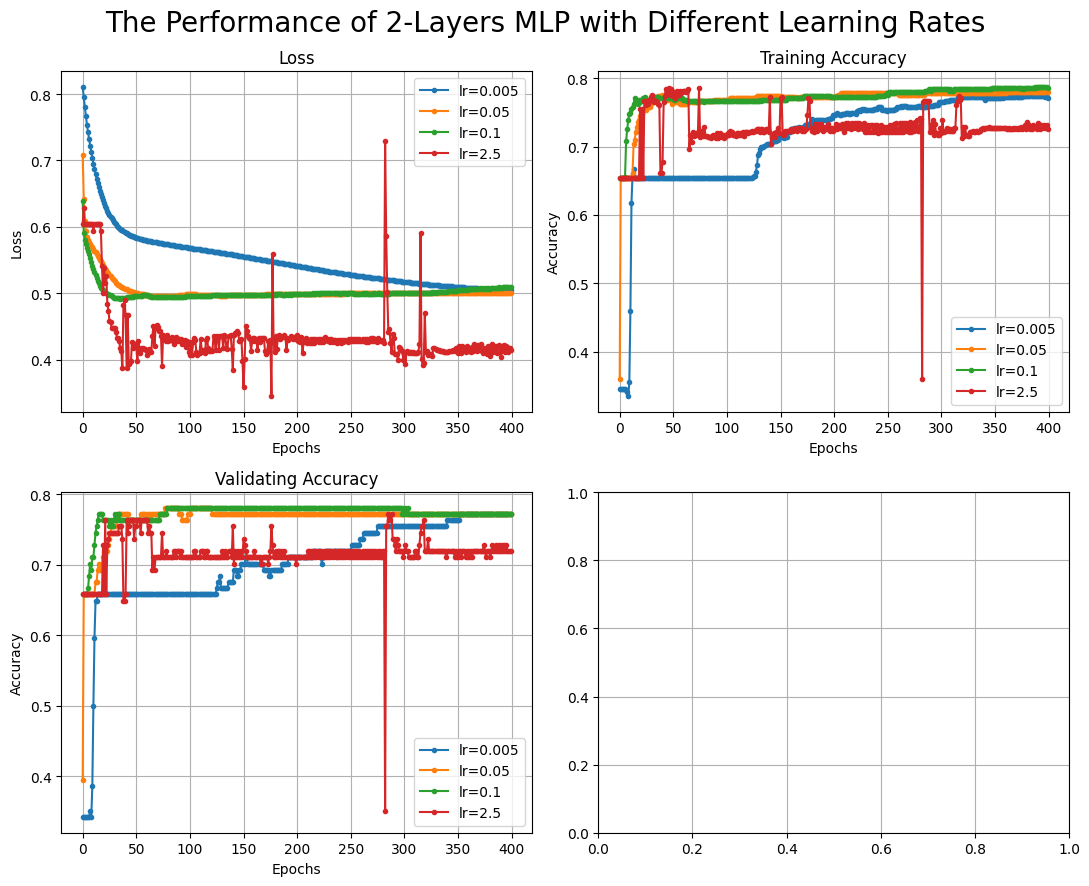

In [302]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

for i, lr in enumerate(lr_lst):
    axes[0,0].plot(epochs, loss_array[i], label=f"lr={lr}", marker='o', markersize=3)
    axes[0,0].set_title("Loss")
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

for i, lr in enumerate(lr_lst):
    axes[0,1].plot(epochs, accuracy_array[i], label=f"lr={lr}", marker='o', markersize=3)
    axes[0,1].set_title("Training Accuracy")
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

for i, lr in enumerate(lr_lst):
    axes[1,0].plot(epochs, accuracy_test_array[i], label=f"lr={lr}", marker='o', markersize=3)
    axes[1,0].set_title("Validating Accuracy")
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()
    axes[1,0].grid(True)

plt.suptitle("The Performance of 2-Layers MLP with Different Learning Rates", fontsize=20)
plt.tight_layout()
plt.grid()
plt.show()




## Batch Size

In [303]:
batch_lst = [10,20,50,80]
loss_array = []
accuracy_array=[]
accuracy_test_array=[]
n_epochs = 400
lr = 0.05
epochs = range(n_epochs)

for i,value in enumerate(batch_lst):
    model1.load_state_dict(torch.load('original_model1.pth'))
    model1.zero_grad()
    loss_lst, accuracy_lst, accuracy_test_lst,_ = mlp(n_epochs
                                                ,value
                                                ,model1 
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,valid_features_tensor
                                                ,valid_labels_tensor
                                                ,lr = lr)
    loss_array.append([loss.detach().numpy() for loss in loss_lst])
    accuracy_array.append([loss.detach().numpy() for loss in accuracy_lst])
    accuracy_test_array.append([loss.detach().numpy() for loss in accuracy_test_lst])
    

Finished epoch 0, latest loss 0.5960904359817505,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 1, latest loss 0.4573931097984314,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 2, latest loss 0.4190932810306549,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 3, latest loss 0.41028067469596863,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 4, latest loss 0.4049793481826782,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 5, latest loss 0.3995683193206787,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 6, latest loss 0.39628058671951294,accuracy 0.7024481892585754,accuracy_valid 0.6666666865348816
Finished epoch 7, latest loss 0.3862924575805664,accuracy 0.7175140976905823,accuracy_valid 0.719298243522644
Finished epoch 8, latest loss 0.37867942452430725,accuracy 0.7344632744789124,accuracy_valid 0.7017543911933899

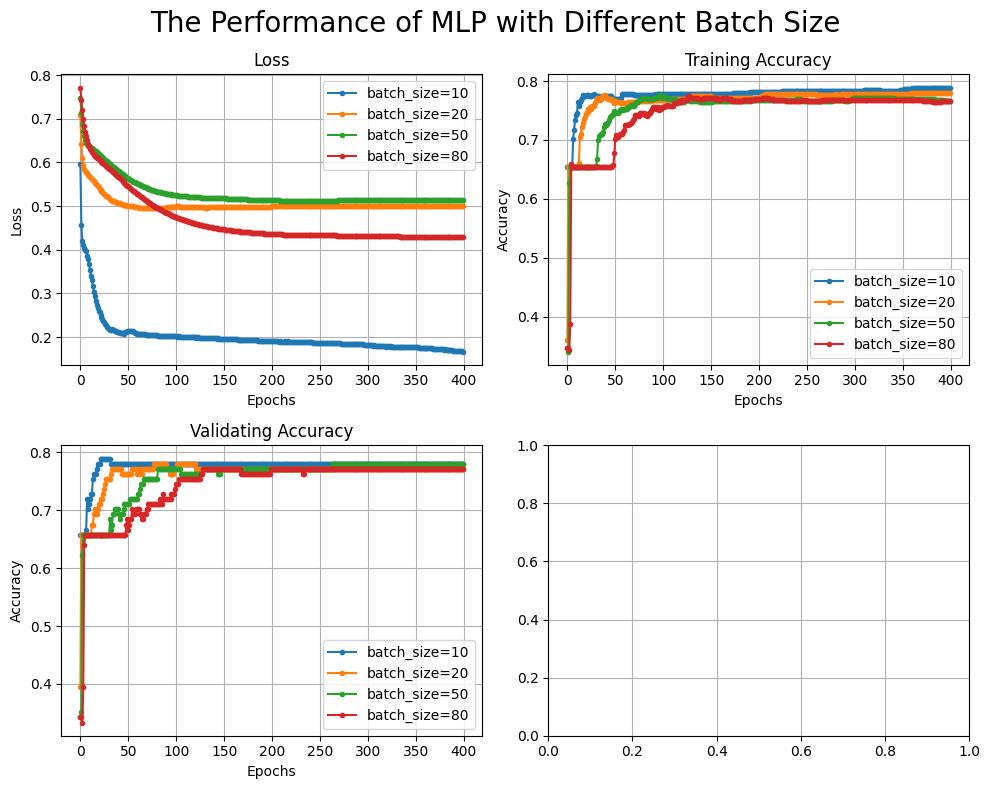

In [304]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, batch in enumerate(batch_lst):
    axes[0,0].plot(epochs, loss_array[i], label=f"batch_size={batch}", marker='o', markersize=3)
    axes[0,0].set_title("Loss")
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

for i, batch in enumerate(batch_lst):
    axes[0,1].plot(epochs, accuracy_array[i], label=f"batch_size={batch}", marker='o', markersize=3)
    axes[0,1].set_title("Training Accuracy")
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

for i, batch in enumerate(batch_lst):
    axes[1,0].plot(epochs, accuracy_test_array[i], label=f"batch_size={batch}", marker='o', markersize=3)
    axes[1,0].set_title("Validating Accuracy")
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()
    axes[1,0].grid(True)

plt.suptitle("The Performance of MLP with Different Batch Size", fontsize=20)
plt.tight_layout()
plt.grid()
plt.show()



In [275]:
# # optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
# # optimizer.zero_grad()
# optimizer = torch.optim.SGD(model1.parameters(), lr=0.05)
# optimizer.zero_grad()
# model1.load_state_dict(torch.load('original_model1.pth'))
# model1.zero_grad()
# loss_fn = nn.BCELoss() # binary cross-entropy
# n_epochs = 400
# batch_size = 20
# accuracy_lst = []
# accuracy_test_lst = []
# loss_lst = []
# for epoch in range(n_epochs):
#     for i in range(0, len(train_features_tensor), batch_size):
#         Xbatch = train_features_tensor[i:i+batch_size]
#         y_pred = model1(Xbatch)
#         ybatch = train_labels_tensor[i:i+batch_size]
#         loss = loss_fn(y_pred, ybatch)
#         optimizer.zero_grad() # clear the last gradient
#         loss.backward() # nn.BCELoss() return a scale value for loss
#                         # other loss function like mse may use loss.mean().backward() to caculate the mena of loss and then caculate gradient 
#         optimizer.step()# update the W and b

#     loss_lst.append(loss)
#     y_pred = model1(train_features_tensor)

#     accuracy = (y_pred.round() == train_labels_tensor).float().mean()
#     accuracy_lst.append(accuracy)

#     ytest_pred = model1(test_features_tensor)

#     accuracy_test = (ytest_pred.round() == test_labels_tensor).float().mean()
#     accuracy_test_lst.append(accuracy_test)

#     print(f'Finished epoch {epoch}, latest loss {loss},accuracy {accuracy},accuracy_test {accuracy_test}')

## Activity Function

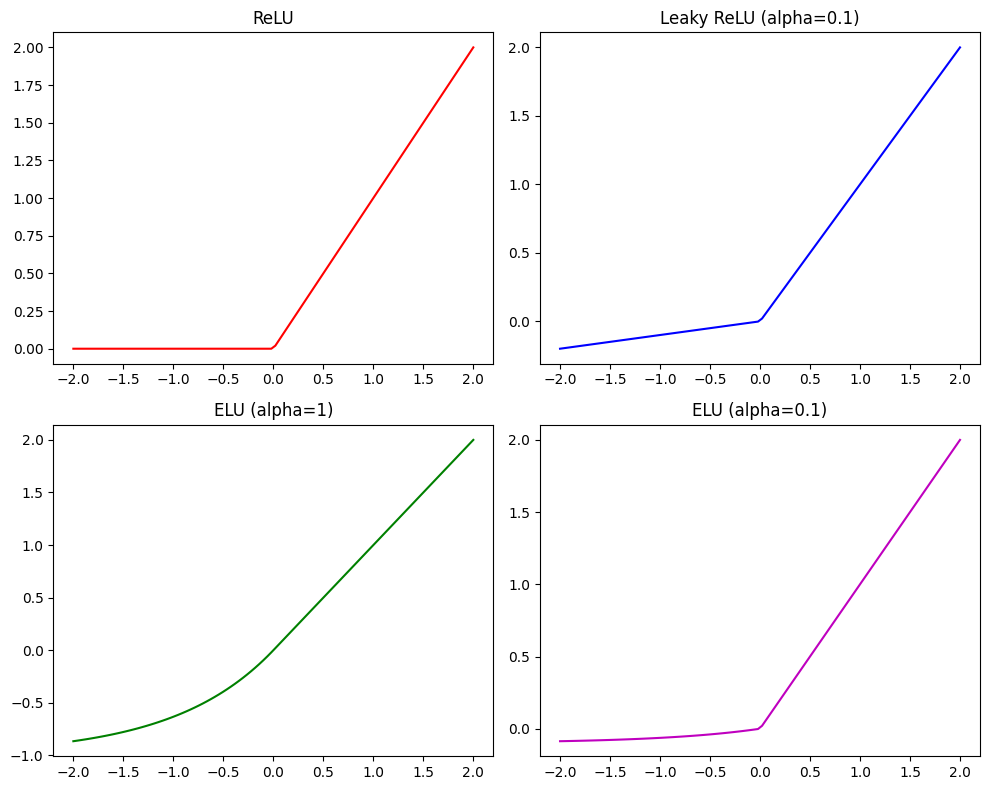

In [346]:

# Define the input range
input_range = np.linspace(-2, 2, 100)

# Define ReLU function
def relu(x):
    return np.maximum(0, x)

# Define Leaky ReLU function
def leaky_relu(x, alpha):
    return np.where(x > 0, x, alpha * x)

# Define ELU function
def elu(x, alpha):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

# Create a 2x2 grid for subplots
plt.figure(figsize=(10, 8))

# Plot ReLU
plt.subplot(2, 2, 1)
plt.plot(input_range, relu(input_range), c="r")
plt.title("ReLU")

# Plot Leaky ReLU with alpha = 0.1
plt.subplot(2, 2, 2)
plt.plot(input_range, leaky_relu(input_range, 0.1), c="b")
plt.title("Leaky ReLU (alpha=0.1)")

# Plot ELU with alpha = 1
plt.subplot(2, 2, 3)
plt.plot(input_range, elu(input_range, 1), c="g")
plt.title("ELU (alpha=1)")

# Plot ELU with alpha = 0.1
plt.subplot(2, 2, 4)
plt.plot(input_range, elu(input_range, 0.1), c="m")
plt.title("ELU (alpha=0.1)")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Finished epoch 0, latest loss 0.6087571978569031,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 1, latest loss 0.6033318042755127,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 2, latest loss 0.6007193922996521,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 3, latest loss 0.6002094745635986,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 4, latest loss 0.5983107089996338,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 5, latest loss 0.5957943797111511,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 6, latest loss 0.5933406949043274,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 7, latest loss 0.5909223556518555,accuracy 0.6553672552108765,accuracy_valid 0.6315789222717285
Finished epoch 8, latest loss 0.5886958837509155,accuracy 0.674199640750885,accuracy_valid 0.640350878238678
Fin

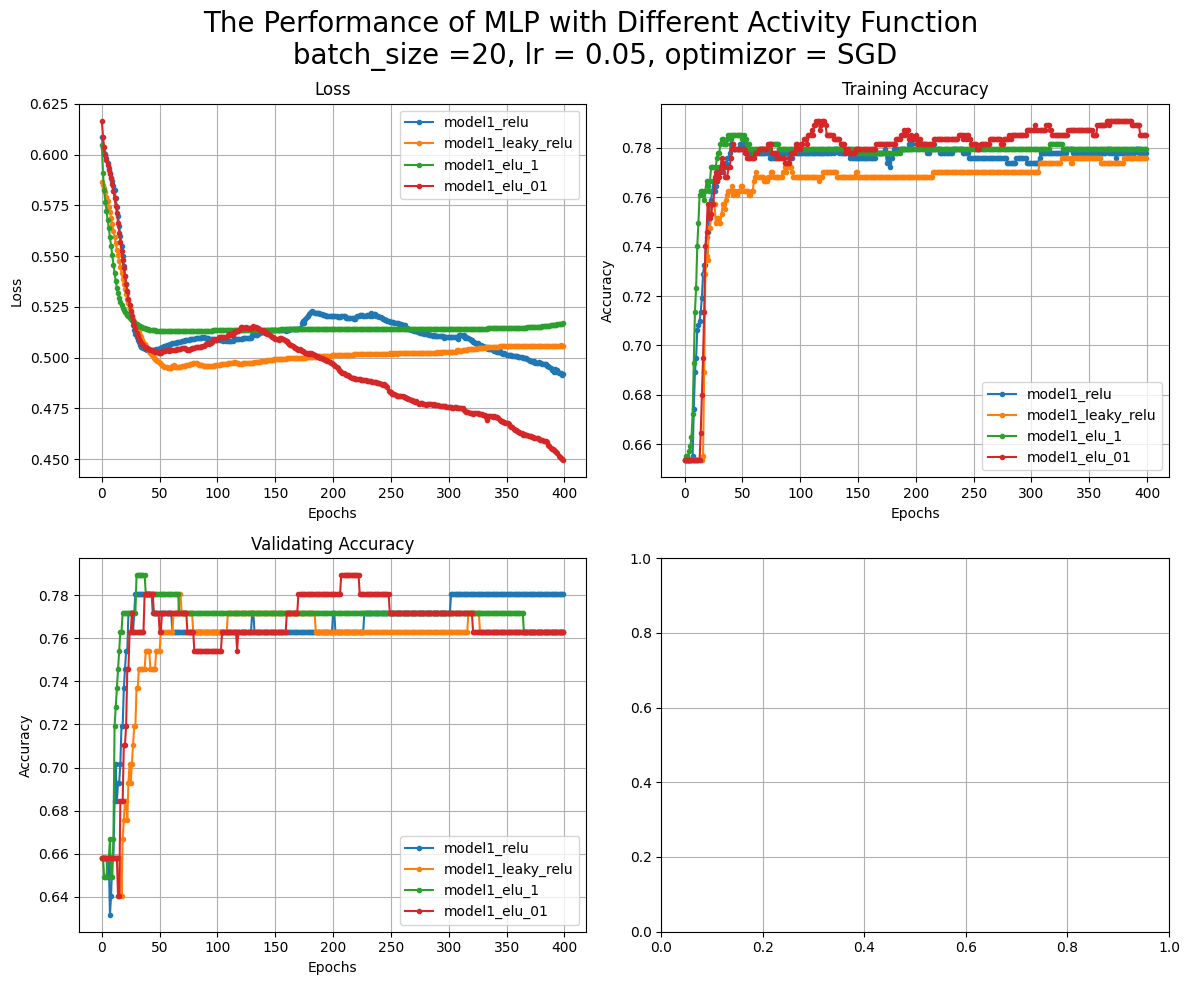

In [309]:
model1_relu = nn.Sequential(
  nn.Linear(8, 4),
  nn.ReLU(),
  nn.Linear(4, 1),
  nn.Sigmoid()    
)

model1_leaky_relu = nn.Sequential(
  nn.Linear(8, 4),
  nn.LeakyReLU(),
  nn.Linear(4, 1),
  nn.Sigmoid()    
)

model1_elu_1 = nn.Sequential(
  nn.Linear(8, 4),
  nn.ELU(alpha=1.0),
  nn.Linear(4, 1),
  nn.Sigmoid()    
)

model1_elu_01 = nn.Sequential(
  nn.Linear(8, 4),
  nn.ELU(alpha=0.1),
  nn.Linear(4, 1),
  nn.Sigmoid()    
)

batch_size = 20
loss_array = []
accuracy_array=[]
accuracy_test_array=[]
n_epochs = 400
lr = 0.05
epochs = range(n_epochs)
model_lst = [model1_relu,model1_leaky_relu,model1_elu_1,model1_elu_01]
model_str = ["model1_relu","model1_leaky_relu","model1_elu_1","model1_elu_01"]
for i,model in enumerate(model_lst):
    loss_lst, accuracy_lst, accuracy_test_lst,_ = mlp(n_epochs
                                                ,batch_size
                                                ,model 
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,valid_features_tensor
                                                ,valid_labels_tensor
                                                ,lr = lr)
    loss_array.append([loss.detach().numpy() for loss in loss_lst])
    accuracy_array.append([loss.detach().numpy() for loss in accuracy_lst])
    accuracy_test_array.append([loss.detach().numpy() for loss in accuracy_test_lst])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, model in enumerate(model_lst):
    axes[0,0].plot(epochs, loss_array[i], label=f"{model_str[i]}", marker='o', markersize=3)
    axes[0,0].set_title("Loss")
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

for i, model in enumerate(model_lst):
    axes[0,1].plot(epochs, accuracy_array[i], label=f"{model_str[i]}", marker='o', markersize=3)
    axes[0,1].set_title("Training Accuracy")
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

for i, model in enumerate(model_lst):
    axes[1,0].plot(epochs, accuracy_test_array[i], label=f"{model_str[i]}", marker='o', markersize=3)
    axes[1,0].set_title("Validating Accuracy")
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()
    axes[1,0].grid(True)

plt.suptitle("The Performance of MLP with Different Activity Function \n batch_size =20, lr = 0.05, optimizor = SGD ", fontsize=20)
plt.tight_layout()
plt.grid()

plt.show()

## Weight Initialization

Finished epoch 0, latest loss 0.6584077477455139,accuracy 0.6553672552108765,accuracy_valid 0.6666666865348816
Finished epoch 1, latest loss 0.6382336020469666,accuracy 0.6553672552108765,accuracy_valid 0.6578947305679321
Finished epoch 2, latest loss 0.6250723600387573,accuracy 0.6553672552108765,accuracy_valid 0.6578947305679321
Finished epoch 3, latest loss 0.6166009902954102,accuracy 0.6516007781028748,accuracy_valid 0.6578947305679321
Finished epoch 4, latest loss 0.6114985346794128,accuracy 0.6516007781028748,accuracy_valid 0.6578947305679321
Finished epoch 5, latest loss 0.6082823872566223,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 6, latest loss 0.6060032248497009,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 7, latest loss 0.604214608669281,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Finished epoch 8, latest loss 0.6018878221511841,accuracy 0.6534839868545532,accuracy_valid 0.6578947305679321
Fi

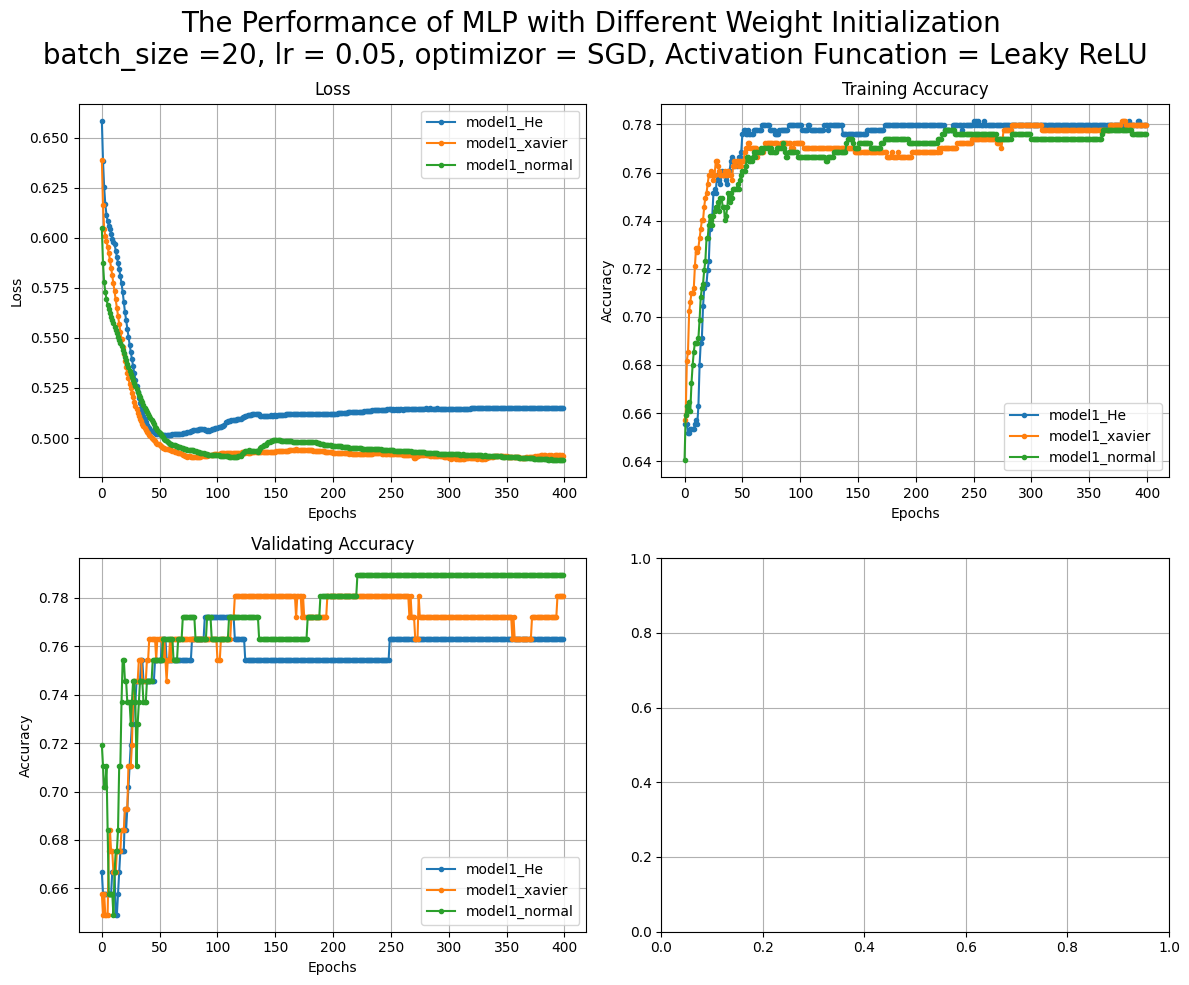

In [311]:
import torch.nn.init as init

def He_init(linear_layer):
    layer_init_He = linear_layer
    init.kaiming_normal_(layer_init_He.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
    init.zeros_(layer_init_He.bias)
    return layer_init_He
  
def xavier_init(linear_layer):
    layer_init_xavier = linear_layer
    init.xavier_normal_(layer_init_xavier.weight, gain = nn.init.calculate_gain('leaky_relu', 0.2))
    init.zeros_(layer_init_xavier.bias)
    return layer_init_xavier
  
def normal_init(linear_layer):
    layer_init_normal = linear_layer
    init.normal_(layer_init_normal.weight)
    init.zeros_(layer_init_normal.bias)
    return layer_init_normal

model1_He = nn.Sequential(
  He_init(nn.Linear(8, 4)),
  nn.LeakyReLU(),
  He_init(nn.Linear(4, 1)),
  nn.Sigmoid()    
)

model1_xavier = nn.Sequential(
  xavier_init(nn.Linear(8, 4)),
  nn.LeakyReLU(),
  xavier_init(nn.Linear(4, 1)),
  nn.Sigmoid()      
)

model1_normal = nn.Sequential(
  normal_init(nn.Linear(8, 4)),
  nn.LeakyReLU(),
  normal_init(nn.Linear(4, 1)),
  nn.Sigmoid()      
)

batch_size = 20
loss_array = []
accuracy_array=[]
accuracy_test_array=[]
n_epochs = 400
lr = 0.05
epochs = range(n_epochs)
model_lst = [model1_He,model1_xavier,model1_normal]
model_str = ["model1_He","model1_xavier","model1_normal"]
for i,model in enumerate(model_lst):
    loss_lst, accuracy_lst, accuracy_test_lst,_ = mlp(n_epochs
                                                ,batch_size
                                                ,model 
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,valid_features_tensor
                                                ,valid_labels_tensor
                                                ,lr = lr)
    loss_array.append([loss.detach().numpy() for loss in loss_lst])
    accuracy_array.append([loss.detach().numpy() for loss in accuracy_lst])
    accuracy_test_array.append([loss.detach().numpy() for loss in accuracy_test_lst])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, model in enumerate(model_lst):
    axes[0,0].plot(epochs, loss_array[i], label=f"{model_str[i]}", marker='o', markersize=3)
    axes[0,0].set_title("Loss")
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

for i, model in enumerate(model_lst):
    axes[0,1].plot(epochs, accuracy_array[i], label=f"{model_str[i]}", marker='o', markersize=3)
    axes[0,1].set_title("Training Accuracy")
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

for i, model in enumerate(model_lst):
    axes[1,0].plot(epochs, accuracy_test_array[i], label=f"{model_str[i]}", marker='o', markersize=3)
    axes[1,0].set_title("Validating Accuracy")
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()
    axes[1,0].grid(True)

plt.suptitle("The Performance of MLP with Different Weight Initialization \n batch_size =20, lr = 0.05, optimizor = SGD, Activation Funcation = Leaky ReLU ", fontsize=20)
plt.tight_layout()
plt.grid()

plt.show()


Finished epoch 0, latest loss 0.5895012021064758,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 1, latest loss 0.5858654975891113,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 2, latest loss 0.582841694355011,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 3, latest loss 0.580066978931427,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 4, latest loss 0.5772206783294678,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 5, latest loss 0.574335515499115,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 6, latest loss 0.5710896253585815,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 7, latest loss 0.5681028962135315,accuracy 0.6534839868545532,accuracy_valid 0.6491228342056274
Finished epoch 8, latest loss 0.5650212168693542,accuracy 0.6591337323188782,accuracy_valid 0.6491228342056274
Fini

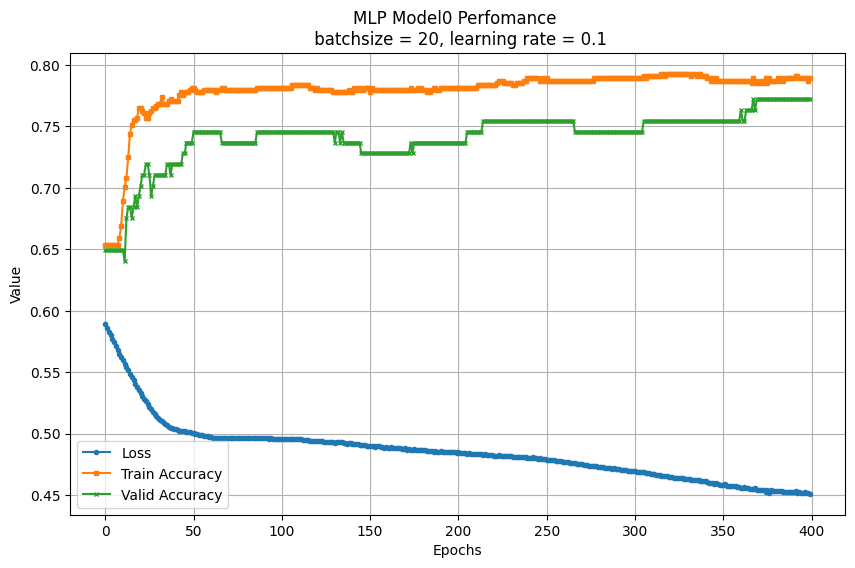

In [333]:

def xavier_init(linear_layer):
    layer_init_xavier = linear_layer
    init.xavier_normal_(layer_init_xavier.weight, gain = nn.init.calculate_gain('leaky_relu', 0.2))
    init.zeros_(layer_init_xavier.bias)
    return layer_init_xavier

model1_xavier = nn.Sequential(
  nn.Linear(8, 4),
  nn.LeakyReLU(0.2),
  nn.Linear(4, 1),
  nn.Sigmoid()      
)
n_epochs = 400
loss_lst, accuracy_lst, accuracy_test_lst,_ = mlp(n_epochs
                                                ,batch_size
                                                ,model1_xavier
                                                ,train_features_tensor
                                                ,train_labels_tensor
                                                ,test_features_tensor
                                                ,test_labels_tensor
                                                ,lr = lr)
loss_array.append([loss.detach().numpy() for loss in loss_lst])
accuracy_array.append([loss.detach().numpy() for loss in accuracy_lst])
accuracy_test_array.append([loss.detach().numpy() for loss in accuracy_test_lst])

learn_curve(n_epochs,loss_lst,accuracy_lst,accuracy_test_lst,param_lst)

In [338]:
ytest_pred = model1_xavier(test_features_tensor)
accuracy_test = (ytest_pred.round() == test_labels_tensor).float().mean()
print("accuracy",accuracy_test.item())

TP = ((ytest_pred.round() == 1) & (test_labels_tensor == 1)).sum().item()
FP = ((ytest_pred.round() == 1) & (test_labels_tensor == 0)).sum().item()
FN = ((ytest_pred.round() == 0) & (test_labels_tensor == 1)).sum().item()
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Precision:", precision)
print("Recall:", recall)








accuracy 0.7719298005104065
Precision: 0.7790697674418605
Recall: 0.9054054054054054


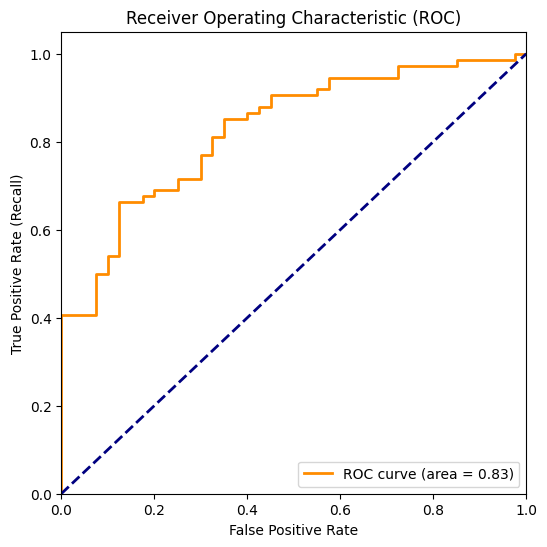

In [345]:
from sklearn.metrics import roc_curve, auc

ytest_prob = model1_xavier(test_features_tensor).detach().numpy()

fpr, tpr, thresholds = roc_curve(test_labels_tensor.numpy(), ytest_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
